# Introduction
- In this kernel, we will be implementing the **Blackjack** environment. A complete and extensive description of the same can be found in the book on **Reinforcement Learning** by **Richard S. Sutton and Andrew G. Barto**. Check out **Example 5.1** (Page - 93).
- We will be deploying Q-Learning to try and find the optimal agent's policy for a given dealer's way of playing, for instance, **HIT if sum < 17, else STICK**. 
- This implementation is based on **RL-Glue**, a standard, language-independent software package for reinforcement-learning experiments. The standardization provided by RL-Glue facilitates code sharing and collaboration. Feel free to read more about it [here](https://jmlr.csail.mit.edu/papers/v10/tanner09a.html), and I borrowed the implementation from [here](https://github.com/andnp/coursera-rl-glue).

# Importing Packages & Boilerplate Stuff

1. jdc: Jupyter magic that allows defining classes over multiple jupyter notebook cells.
2. numpy: the fundamental package for scientific computing with Python.
3. matplotlib: the library for plotting graphs in Python.
4. RL-Glue: the library for reinforcement learning experiments.
5. BaseEnvironment, BaseAgent: the base classes from which we will inherit when creating the environment and agent classes in order for them to support the RL-Glue framework.
6. itertools.product: the function that can be used easily to compute permutations.
7. tqdm.tqdm: Provides progress bars for visualizing the status of loops.

In [1]:
import jdc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from rl_glue import RLGlue
from Agent import BaseAgent 
from Environment import BaseEnvironment
from itertools import product
from tqdm import tqdm

In [2]:
### DEBUG CODE
# Setting the seed for reproducible results
# np.random.seed(0)

# 1. Environment
- When the agent's sum <= 11, the agent will always hit, so, there's no need to simulate any policy for that part of the interaction. This part of the interaction has thus been simulated (*without any policy*) in `env_start` in the beginning of each episode.
-  During this simulation, if the agent's cards sum to 21, then we define this as a **NATURAL** (*slightly different from the book*). As per the the book, a **NATURAL** is defined as the case when the 2 cards dealt to the player sum to 21. 
- The below code cell provides the backbone of the `BlackjackEnvironment` class.

In [3]:
class BlackjackEnvironment(BaseEnvironment):
    def env_init(self, env_info={}):
        raise NotImplementedError

    def env_start(self):
        raise NotImplementedError

    def env_step(self, action):
        raise NotImplementedError

    def env_cleanup(self):
        raise NotImplementedError
        
    # Helper method
    def episode_reward(self):
        raise NotImplementedError
        
    # Helper method
    def get_dealer_sum(self):
        raise NotImplementedError
        
    # Helper method
    def set_reward_state_term(self, reward, is_terminal):
        raise NotImplementedError

## 1.1. env_init()
- All the characteristics of the environment that are constant throughout the episodes are defined in this method.
- For simplicity purposes, I have defined all the variables that are varying across the episodes in this method as well, and simply set them to `None`.
- This is being done so that we can find all the characteristics of the environment and agent that we require for this experiment in a single method. 
- The only characteristic of the environment that can be modified is the **dealer's policy**, and it can be set using the `dealer_sticks` key of the `env_info` dictionary.

In [4]:
%%add_to BlackjackEnvironment

def env_init(self, env_info={}):
    """
    Setup for the environment called when the experiment first starts.
    Args:
        env_info: Contains the information for the environment
    """
    
    # Defines the current state; a tuple of 
    # (dealer's visible card, agent sum, boolean indicating presence of a usable ace)
    self.cur_state = None
    
    # Defines the current reward, state, and whether this is a terminal state or not
    self.reward_state_term = None
    
    # Dictionaries mapping each state to an index & vice-versa
    self.state_to_index = {}
    self.index_to_state = {}
    
    # Iterating over all the possible 200 states
    i = 0
    for ag_sum in range(12, 22):
        for dea_vc in range(2, 12): # Dealer's Visible Card
            for us_ace in [False, True]: # Usable Ace
                self.index_to_state[i] = (dea_vc, ag_sum, us_ace)
                self.state_to_index[(dea_vc, ag_sum, us_ace)] = i
                i += 1
    
    # Defining the card probabilities
    self.card_probs = {}
    for i in range(2, 10):
        self.card_probs[i] = (1 / 13)
    self.card_probs[10] = (4 / 13)
    self.card_probs[11] = (1 / 13)
    
    # How to access the dictionary
    # list(self.card_probs.keys()) gives us the possible cards
    # list(self.card_probs.values()) gives us the probablities
    
    self.dealer_sticks = env_info.get("dealer_sticks", 17)
    self.dealer_card_up = None
    self.dealer_card_down = None
    
    # Initializing the default values for the agent
    self.agent_sum = None
    self.agent_usable_ace = None
    self.is_natural = None

## 1.2. env_start()
- All the characteristics of the environment that are varying across the episodes are defined in this method.
- This includes characteristics like `dealer_card_up`, `dealer_card_down`, `agent_sum`, `agent_usable_ace` and `is_natural`.

In [5]:
%%add_to BlackjackEnvironment

def env_start(self):
    """
    The first method called when the episode starts, called before the
    agent starts.
    Returns:
        The first state from the environment.
    """
    
    ### DEBUG CODE
    # seed = np.random.choice(range(10000))
    # np.random.seed(seed)
    
    # Initializing the starting values for the environment
    self.dealer_card_up = np.random.choice(range(2, 12), replace = True, 
        p = list(self.card_probs.values()))
    self.dealer_card_down = np.random.choice(range(2, 12), replace = True, 
        p = list(self.card_probs.values()))
    
    # Initializing the starting values for the agent
    self.agent_sum = 0
    self.agent_usable_ace = False
    self.is_natural = False
    
    while self.agent_sum < 12:
        card_drawn = np.random.choice(range(2, 12), replace = True, 
            p = list(self.card_probs.values()))
        if card_drawn == 11: self.agent_usable_ace = True
        self.agent_sum += card_drawn
        
    if self.agent_sum == 22:
        self.agent_sum -= 10
        self.set_reward_state_term(0, False)
    
    elif self.agent_sum == 21:
        self.is_natural = True
        reward = self.episode_reward()
        self.set_reward_state_term(reward, True)
    
    else:
        self.set_reward_state_term(0, False)
    
    ### DEBUG CODE
    # print("Starting Reward:", self.reward_state_term[0])
    # print("Starting State:", self.index_to_state[self.reward_state_term[1]])
    # print("Starting Bool:", self.reward_state_term[2])
    
    return self.reward_state_term[1]

## 1.3. env_step()
- As per RL-Glue's implementation, `env_start` considers that the agent can't be in the terminal state when an episode starts. 
- Hence, the `env_start` only returns the state (*which is assumed to be a non-terminal state*), and doesn't return the boolean indicating whether this is a terminal state or not.
- However, in the Blackjack environment, it is possible for the agent to reach the terminal state even when an episode starts, i.e., the case of a **NATURAL**. For the definition of a **NATURAL**, refer to Section 1: Environment.
- In order to account for a **NATURAL**, a specific property has been set for each episode, `is_natural`, and if this is **TRUE**, the agent doesn't have to take any steps, and hence, it simply returns without any simulation from `env_step`.

In [6]:
%%add_to BlackjackEnvironment

def env_step(self, action):
    """
    A step taken by the environment.
    Args:
        action: The action taken by the agent
    Returns:
        (reward, state, boolean): a tuple of the reward, state,
            and boolean indicating if it's terminal.
    """
    
    # Case in which a NATURAL happens, i.e., the agent comes up with 21
    if self.is_natural:
        reward = self.episode_reward()
        self.set_reward_state_term(reward, True)
        return self.reward_state_term
    
    # The agent sticks; always lead to terminal state
    # None of the 3 variables in the state changes
    if action == 0:
        reward = self.episode_reward()
        self.set_reward_state_term(reward, True)
        
    # The agent hits; may or may not lead to terminal state
    elif action == 1:
        # Draw a card
        card_drawn = np.random.choice(range(2, 12), replace = True, 
            p = list(self.card_probs.values()))
        
        # Assuming that if an ace is drawn, it is usable
        # Will change it further down the code
        if card_drawn == 11: self.agent_usable_ace = True
        self.agent_sum += card_drawn
        
        # The agent doesn't have a usable ace
        if not self.agent_usable_ace:
            if self.agent_sum > 21:
                self.agent_sum -= card_drawn
                self.set_reward_state_term(-1, True)
            elif self.agent_sum == 21:
                reward = self.episode_reward()
                self.set_reward_state_term(reward, True)
            else:
                self.set_reward_state_term(0, False)
            
        # The agent does have a usable ace
        else:
            if self.agent_sum > 21:
                self.agent_usable_ace = False
                self.agent_sum -= 10
                
                if self.agent_sum == 21:
                    reward = self.episode_reward()
                    self.set_reward_state_term(reward, True)
                else:
                    self.set_reward_state_term(0, False)
            
            elif self.agent_sum == 21:
                reward = self.episode_reward()
                self.set_reward_state_term(reward, True)
            else:
                self.set_reward_state_term(0, False)
    
    return self.reward_state_term

## 1.4. env_cleanup()
- This method sets the environment attributes to their default values once the experiment terminates.

In [7]:
%%add_to BlackjackEnvironment

def env_cleanup(self):
    """Cleanup done after the environment ends"""
    
    # Default values for the environment
    self.cur_state = None
    self.reward_state_term = None
    self.dealer_card_up = None
    self.dealer_card_down = None
    
    # Default values for the agent
    self.agent_sum = None
    self.agent_usable_ace = None
    self.is_natural = None

## 1.5. episode_reward(), get_dealer_sum() and set_reward_state_term()
- These are some simple helper methods for the `BlackjackEnvironment`. 
- `episode_reward` calculates the reward for an episode, once the agent's turn is over.
- `get_dealer_sum` calculates the dealer sum once the episode terminates, which is used by `episode_reward` to determine the reward for an episode.
- `set_reward_state_term` derives the current state from the environment attributes: `dealer_card_up`, `agent_sum` and `agent_usable_ace`, and then uses the current state to define the `cur_state` and `reward_state_term` attributes of the environment.

In [8]:
%%add_to BlackjackEnvironment

def episode_reward(self):
    """
    Returns:
        reward: the reward for an episode, after the agent's turn is over
    """
    
    dealer_sum = self.get_dealer_sum()
            
    # Dealer goes bust; agent wins the episode
    if dealer_sum > 21: reward = 1
    # The episode results in a draw
    elif dealer_sum == self.agent_sum: reward = 0
    # The dealer wins due to a greater sum
    elif dealer_sum > self.agent_sum: reward = -1
    # The agent wins due to a greater sum
    elif self.agent_sum > dealer_sum: reward = 1
    
    return reward

def get_dealer_sum(self):
    """
    Returns:
        dealer_sum: the sum of the dealer's cards
    """
    
    dealer_sum = 0
    dealer_usable_ace = False
    
    # Account for the 2 cards that the dealer has been already dealt with
    for card in [self.dealer_card_up, self.dealer_card_down]:
        if card == 11: dealer_usable_ace = True
        dealer_sum += card
    
    # Dealer still has a usable ace, since he has 2 aces
    if dealer_sum == 22: dealer_sum -= 10
    
    # Keep on hitting until the dealer's cards sum to atleast self.dealer_sticks
    while dealer_sum < self.dealer_sticks:
        card_drawn = np.random.choice(range(2, 12), replace = True, 
            p = list(self.card_probs.values()))
        dealer_sum += card_drawn
        
        # Dealer has an ace already
        if dealer_usable_ace:
            # The new card dealt is also an ace
            if dealer_sum > 21 and card_drawn == 11:
                dealer_sum -= 10
            # The new card dealt is not an ace
            elif dealer_sum > 21 and card_drawn != 11:
                dealer_sum -= 10
                dealer_usable_ace = False
        
        # Dealer doesn't have an ace yet
        else:
            # The new card dealt is an ace
            if dealer_sum > 21 and card_drawn == 11:
                dealer_sum -= 10
            # The sum is still less & the new card dealt is an ace
            elif dealer_sum <= 21 and card_drawn == 11:
                dealer_usable_ace = True
                
    return dealer_sum

def set_reward_state_term(self, reward, is_terminal):
    """Sets the cur_state and reward_state_term of the environment"""
    
    state = (self.dealer_card_up, self.agent_sum, self.agent_usable_ace)
    self.cur_state = self.state_to_index[state]
    self.reward_state_term = (reward, self.cur_state, is_terminal)

# 2. Agent
- The below code cell provides the backbone of the `QLearningAgent` class.

In [9]:
class QLearningAgent(BaseAgent):
    def agent_init(self, agent_info={}):
        raise NotImplementedError
        
    def agent_start(self, state):
        raise NotImplementedError

    def agent_step(self, reward, state):
        raise NotImplementedError

    def agent_end(self, reward):
        raise NotImplementedError
        
    def agent_message(self, message):
        raise NotImplementedError

    # Helper method
    def argmax(self, q_values):        
        raise NotImplementedError

## 2.1. agent_init()

- All the characteristics of the agent that are constant throughout the episodes are defined in this method.
- The characteristics of the agent that can be modified are the **discount factor, step-size and the epsilon for exploration-exploitation trade-off**. They can be set using the `discount`, `step_size` and `epsilon` keys of the `agent_info` dictionary.

In [10]:
%%add_to QLearningAgent

def agent_init(self, agent_info = {}):
    """
    Setup for the agent called when the experiment first starts.
    Args:
        agent_info: Contains the information for the agent
    """
    
    # Defining the #actions and #states 
    self.num_actions = 2
    self.num_states = 200
    
    # Discount factor (gamma) to use in the updates.
    self.discount = agent_info.get("discount", 0.1)
    
    # The learning rate or step size parameter (alpha) to use in updates.
    self.step_size = agent_info.get("step_size", 0.1)
    
    # To control the exploration-exploitation trade-off
    self.epsilon = agent_info.get("epsilon", 0.1)
    
    # Defining the initial action values
    self.q = np.zeros((self.num_states, self.num_actions))
    
    # Defining a random generator
    self.rand_generator = np.random.RandomState(agent_info.get("seed", 0))

## 2.2. agent_start()
- This method is called at the starting of each episode, and it receives the starting state of each episode.

In [11]:
%%add_to QLearningAgent

def agent_start(self, state):
    """
    The first method called when the episode starts, called after
    the environment starts.
    Args:
        state (int): the state observation from the environment's env_start method.
    Returns:
        action (int): the first action the agent takes.
    """
    
    # Choose action using epsilon greedy.
    current_q = self.q[state][:]
    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.randint(self.num_actions)
    else:
        action = self.argmax(current_q)
    self.prev_state = state
    self.prev_action = action
    return action

## 2.3. agent_step()
- This method is called throughout the episode until the agent reaches the terminal state.

In [12]:
%%add_to QLearningAgent

def agent_step(self, reward, state):
    """
    A step taken by the agent.
    Args:
        reward (float): the reward received for taking the last action taken
        state (int): the state observation from the environment's step 
            based on where the agent ended up after the last step.
    Returns:
        action (int): the action the agent is taking.
    """

    # Choose action using epsilon greedy.
    current_q = self.q[state, :]
    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.randint(self.num_actions)
    else:
        action = self.argmax(current_q)

    # Perform an update
    max_val = -1e8
    for act in range(self.num_actions):
        val = self.q[self.prev_state, self.prev_action] + self.step_size * (
            reward + self.discount * self.q[state, act] - self.q[self.prev_state, self.prev_action]
        )
        max_val = max(max_val, val)
    self.q[self.prev_state, self.prev_action] = max_val

    self.prev_state = state
    self.prev_action = action
    return action

## 2.4. agent_end()
- This method is called when the agent reaches the terminal state, i.e., the end of an episode.

In [13]:
%%add_to QLearningAgent

def agent_end(self, reward):
    """
    Run when the agent terminates.
    Args:
        reward (float): the reward the agent received for entering the
            terminal state.
    """
    max_val = -1e8
    for action in range(self.num_actions):
        val = self.q[self.prev_state, self.prev_action] + self.step_size * (
            reward + self.discount * 0 - self.q[self.prev_state, self.prev_action]
        )
        max_val = max(max_val, val)
    self.q[self.prev_state, self.prev_action] = max_val

## 2.5. agent_message()
- This is just a method to get some information from the agent's attributes, for instance, the Q-Values.

In [14]:
%%add_to QLearningAgent

def agent_message(self, message):
    """
    A method used to pass information from the agent to the experiment.
    Args:
        message: The message passed to the agent
    Returns:
        The response (or answer) to the message
    """
    if message == "get_values":
        return self.q
    else:
        raise Exception("TDAgent.agent_message(): Message not understood!")

## 2.6. argmax()
- This is just a helper method. `np.argmax` doesn't break the ties randomly, hence, we have written a custom implementation of `argmax` which does exactly that.

In [15]:
%%add_to QLearningAgent

def argmax(self, q_values):
    """
    argmax with random tie-breaking
    Args:
        q_values (Numpy array): the array of action-values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

# 3. Plotting Functions
- In this section, I have defined 2 plotting functions:
    - `plt_opt_policy`: It plots the optimal policy corresponding to the current Q-Values.
    - `plt_opt_val`: It plots the optimal state values corresponding to the current Q-Values.

In [16]:
# Creating the Dictionaries outside the environment
state_to_index = {}
index_to_state = {}

# Iterating over all the possible 200 states
i = 0
for ag_sum in range(12, 22):
    for dea_vc in range(2, 12): # Dealer's Visible Card
        for us_ace in [False, True]: # Usable Ace
            index_to_state[i] = (dea_vc, ag_sum, us_ace)
            state_to_index[(dea_vc, ag_sum, us_ace)] = i
            i += 1

In [17]:
def plt_opt_policy(q_policy):
    """
    Function for plotting the optimal policy
    Args:
        q_policy (Numpy array): The Q-values corresponding to the policy found
    """
    
    ### DEBUG CODE
    # state = (4, 13, True)
    # index = state_to_index[state]
    # q_policy[index]
    
    player_sum = list(range(12, 22))
    dealer_card = list(range(2, 12))
    usable_ace = [False, True]
    
    q_vals = np.zeros((len(player_sum), len(dealer_card), 2))

    for i, ps in enumerate(player_sum):
        for j, dc in enumerate(dealer_card):
            for k, ua in enumerate(usable_ace):
                state = (dc, ps, ua)
                index = state_to_index[state]
                q_vals[i][j][k] = np.argmax(q_policy[index])
                
    # Re-organizing the q-values in the correct form
    q_false_vals = np.flip(q_vals[ : , : , 0], axis = 0)
    q_true_vals = np.flip(q_vals[ : , : , 1], axis = 0)
    
    # Defining Subplots
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize = (12, 8))

    im1 = ax1.imshow(q_false_vals)
    ax1.set_title(f"Optimal Policy\n\
        Dealer Sticks: {env_info['dealer_sticks']} | Usable Ace: False\n\
        Purple: STICK | Yellow: HIT\n")
    ax1.set_xlabel("Dealer Card")
    ax1.set_ylabel("Player's Cards' Sum")
    ax1.set_xticks(ticks = range(0, 10), labels = dealer_card)
    ax1.set_yticks(ticks = range(0, 10), labels = np.flip(player_sum))
    
    im2 = ax2.imshow(q_true_vals)
    ax2.set_title(f"Optimal Policy\n\
        Dealer Sticks: {env_info['dealer_sticks']} | Usable Ace: True\n\
        Purple: STICK | Yellow: HIT\n")
    ax2.set_xlabel("Dealer Card")
    ax2.set_ylabel("Player's Cards' Sum")
    ax2.set_xticks(ticks = range(0, 10), labels = dealer_card)
    ax2.set_yticks(ticks = range(0, 10), labels = np.flip(player_sum))
    
    plt.show()

In [18]:
def plt_opt_val(q_policy):
    """
    Function for plotting the optimal state value function
    Args:
        q_policy (Numpy array): The Q-values corresponding to the policy found
    """
    
    ### DEBUG CODE
    # state = (4, 13, True)
    # index = state_to_index[state]
    # print(q_policy[index])

    player_sum = list(range(12, 22))
    dealer_card = list(range(2, 12))
    usable_ace = [False, True]
                
    s_vals = np.zeros((len(player_sum), len(dealer_card), 2))

    for i, ps in enumerate(player_sum):
        for j, dc in enumerate(dealer_card):
            for k, ua in enumerate(usable_ace):
                state = (dc, ps, ua)
                index = state_to_index[state]
                s_vals[i][j][k] = np.max(q_policy[index])
                
    s_false_vals = np.flip(s_vals[ : , : , 0], axis = 0)
    s_true_vals = np.flip(s_vals[ : , : , 1], axis = 0)
    
    # Defining Subplots
    fig = plt.figure(constrained_layout=True, figsize = (10, 8))
    gs = GridSpec(4, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0:3, 0])
    ax2 = fig.add_subplot(gs[0:3, 1])
    ax3 = fig.add_subplot(gs[3, : ])
    
    im1 = ax1.imshow(s_false_vals)
    ax1.set_title(f"Optimal State Value Function\n\
        Dealer Sticks: {env_info['dealer_sticks']} | Usable Ace: False\n")
    ax1.set_xlabel("Dealer Card")
    ax1.set_ylabel("Player's Cards' Sum")
    ax1.set_xticks(ticks = range(0, 10), labels = dealer_card)
    ax1.set_yticks(ticks = range(0, 10), labels = np.flip(player_sum))
    
    im2 = ax2.imshow(s_true_vals)
    ax2.set_title(f"Optimal State Value Function\n\
        Dealer Sticks: {env_info['dealer_sticks']} | Usable Ace: True\n")
    ax2.set_xlabel("Dealer Card")
    ax2.set_ylabel("Player's Cards' Sum")
    ax2.set_xticks(ticks = range(0, 10), labels = dealer_card)
    ax2.set_yticks(ticks = range(0, 10), labels = np.flip(player_sum))
    
    plt.colorbar(im2, cax = ax3, orientation = 'horizontal')
    plt.show()

# 4. Running Experiments

In [19]:
def run_experiment(env_info, agent_info, num_episode = 1000, plot = True):
    env = BlackjackEnvironment
    agent = QLearningAgent
    rl_glue = RLGlue(env, agent)

    rl_glue.rl_init(agent_info, env_info)
    
    for episode in range(1, num_episode + 1):
        rl_glue.rl_episode(0)
        if episode == num_episode: break
        
        if episode % np.ceil(num_episode / 5) == 0:
            q_vals = rl_glue.agent.agent_message("get_values")
            if plot:
                print(f"After {episode} episodes:")
                plt_opt_policy(q_vals)
                plt_opt_val(q_vals)
            
    q_vals = rl_glue.agent.agent_message("get_values")
    if plot:
        print(f"After {num_episode} episodes:")
        plt_opt_policy(q_vals)
        plt_opt_val(q_vals)
    
    return q_vals

## 4.1. Dealer Sticks at 19

After 4000 episodes:


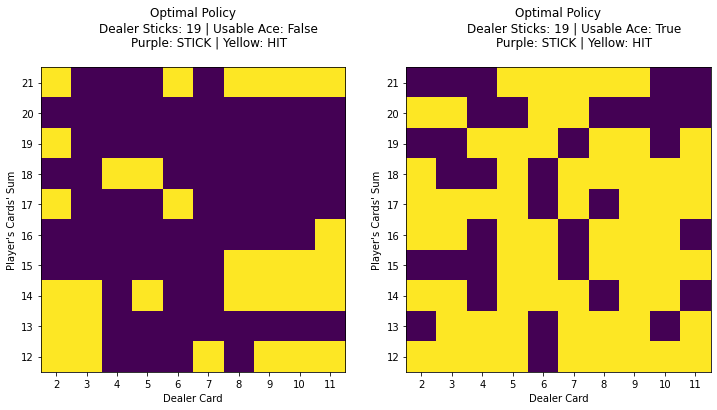

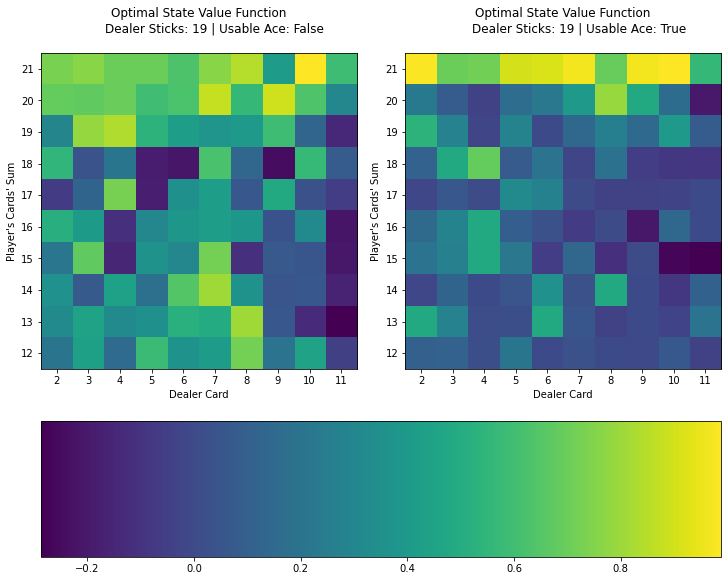

After 8000 episodes:


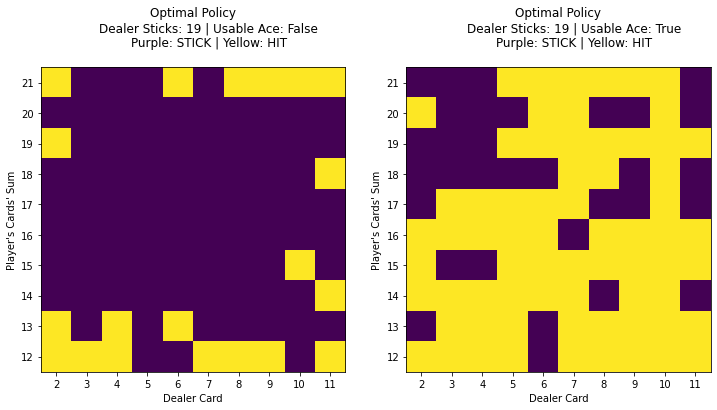

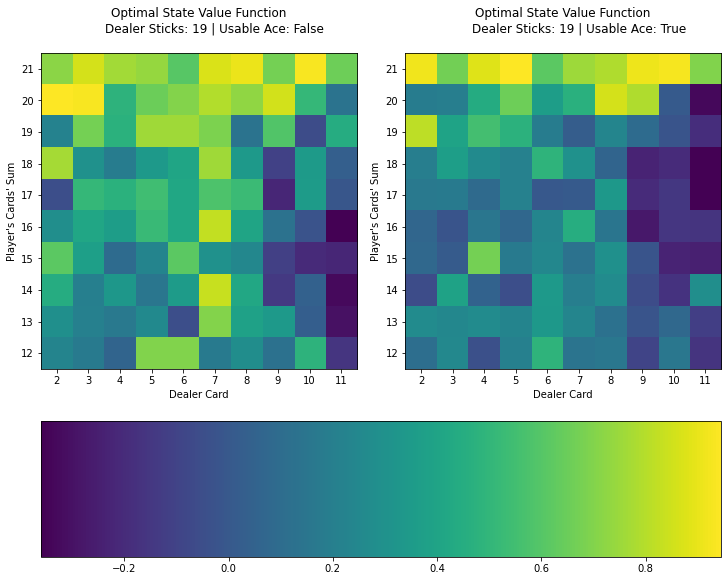

After 12000 episodes:


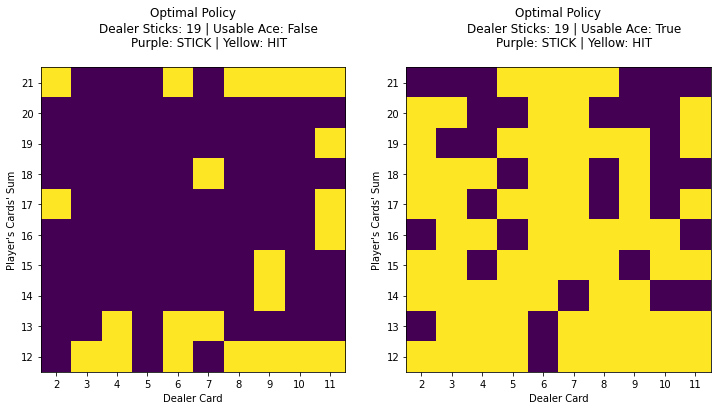

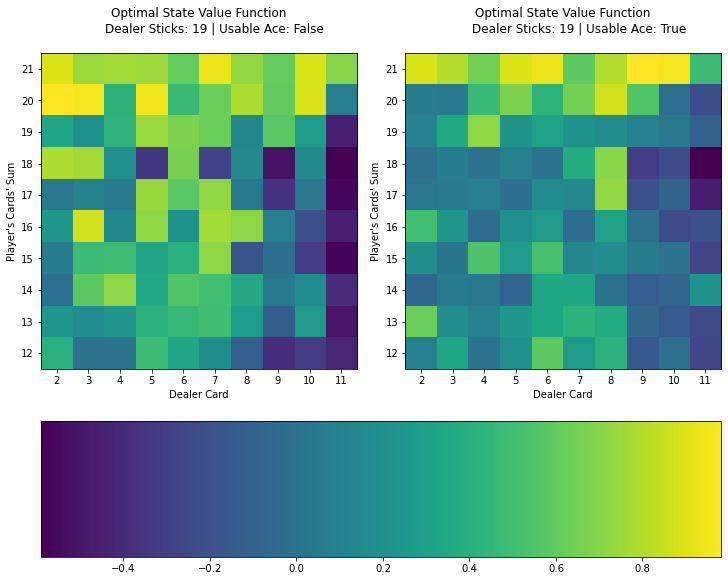

After 16000 episodes:


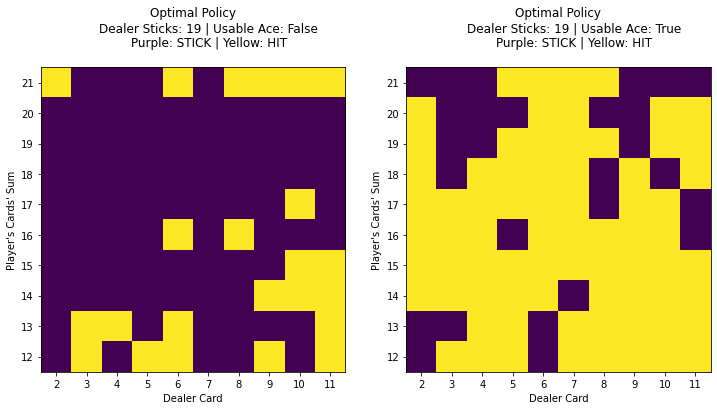

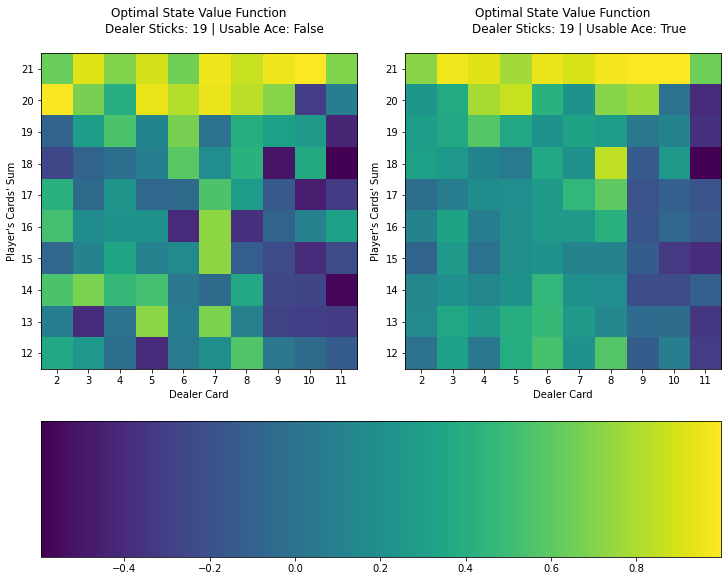

After 20000 episodes:


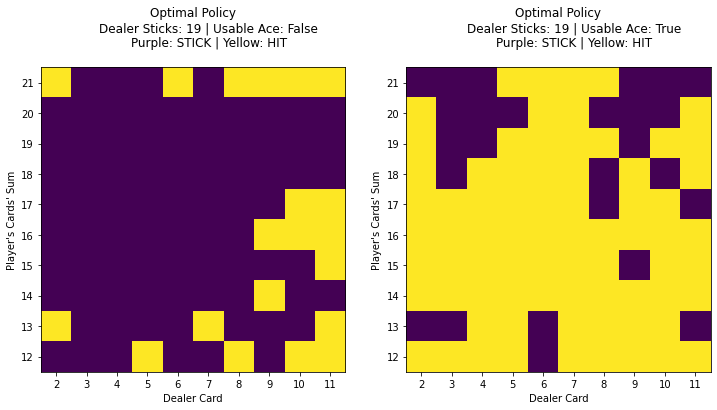

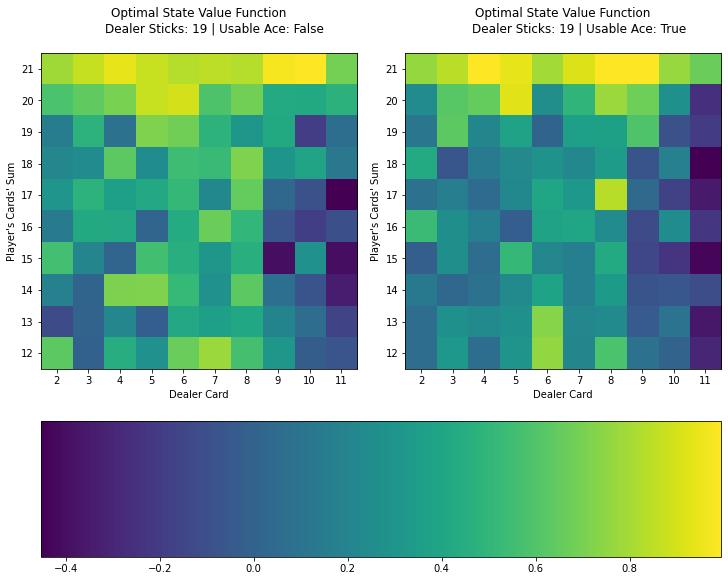

In [20]:
# Defining the characteristics for the environment
env_info = {"dealer_sticks": 19}

# Defining the characteristics for the agent
agent_info = {
    "discount": 1,       # UNDISCOUNTED
    "step_size": 0.2,
    "epsilon": 0.1,
    "seed": 0
}

q_optimal = run_experiment(env_info, agent_info, num_episode = 20000, plot = True)

## 4.2. Dealer Sticks at 17

After 4000 episodes:


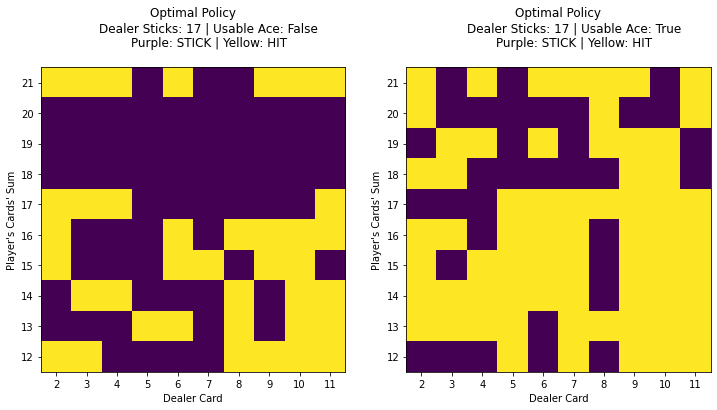

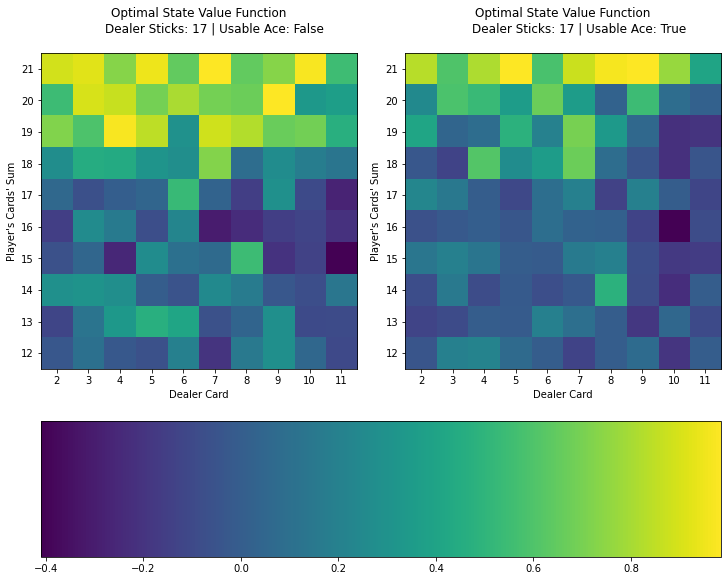

After 8000 episodes:


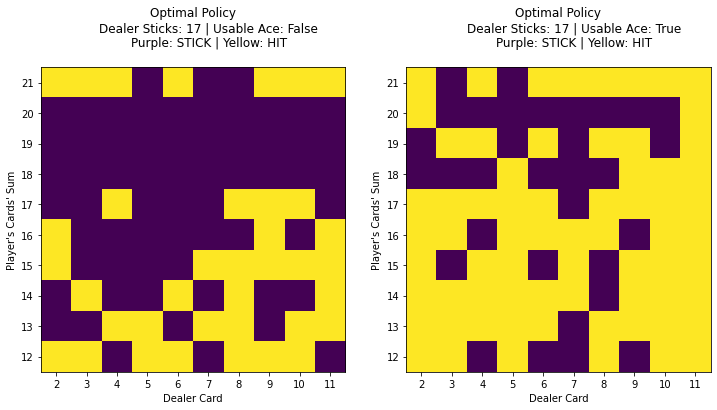

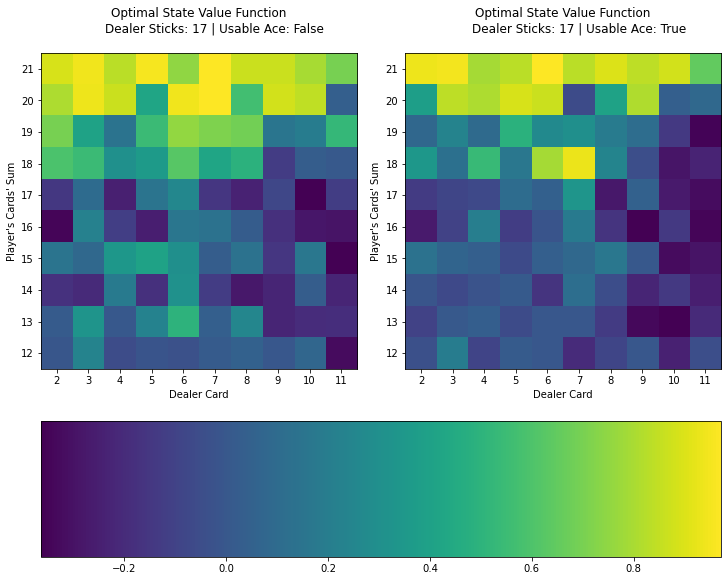

After 12000 episodes:


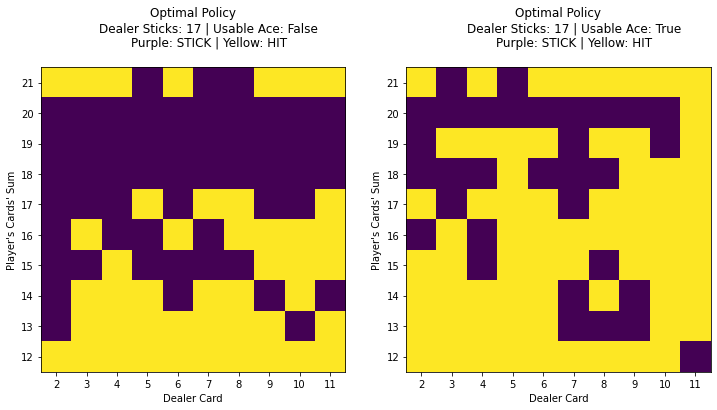

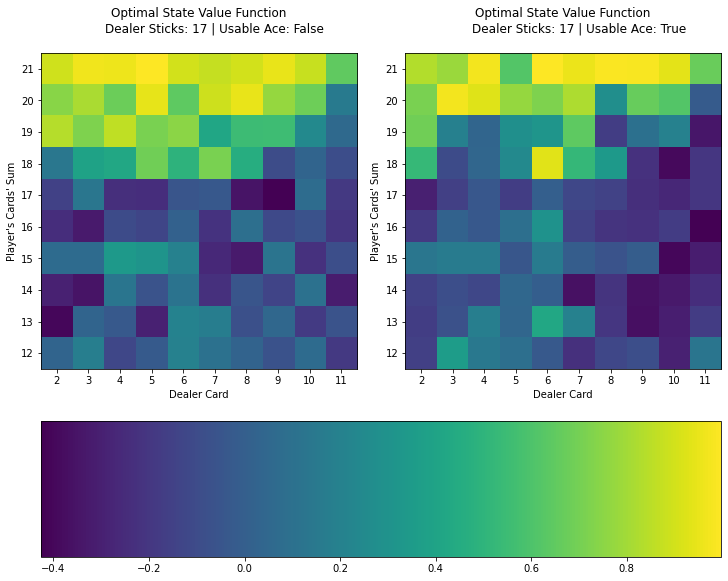

After 16000 episodes:


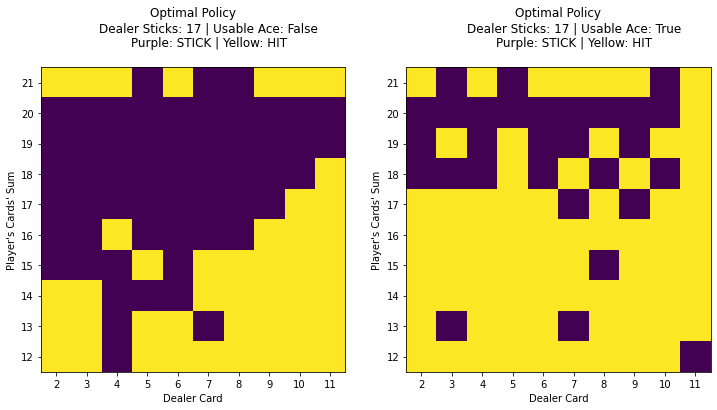

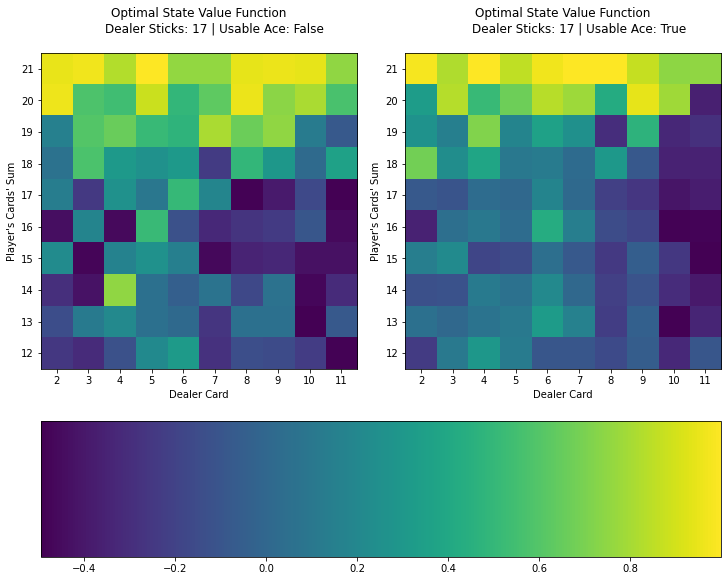

After 20000 episodes:


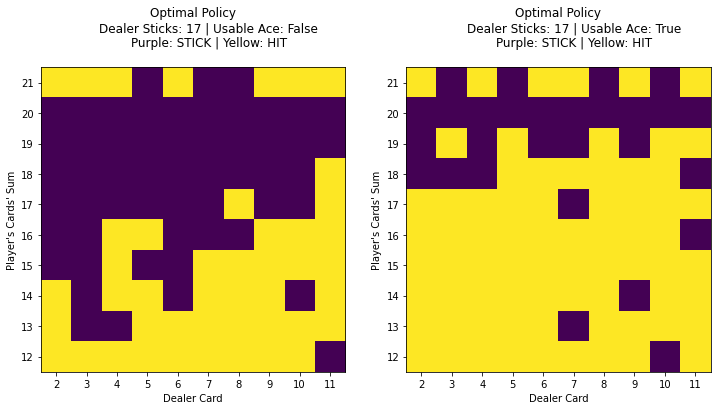

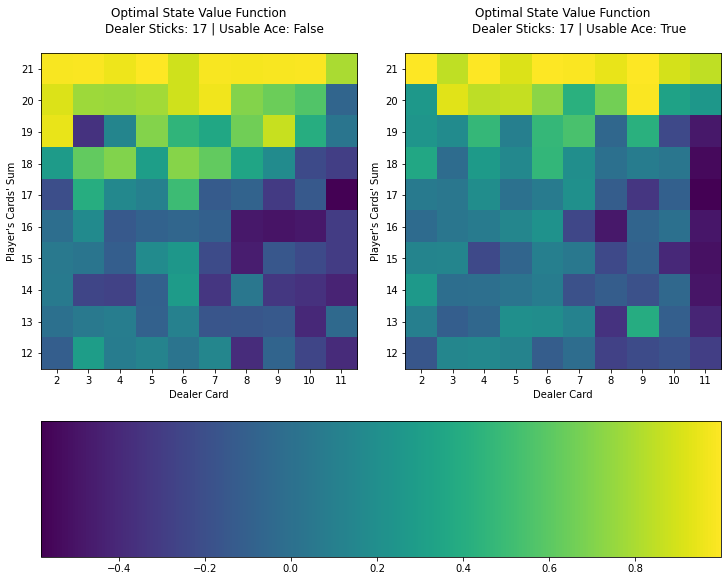

In [21]:
# Defining the characteristics for the environment
env_info = {"dealer_sticks": 17}

# Defining the characteristics for the agent
agent_info = {
    "discount": 1,       # UNDISCOUNTED
    "step_size": 0.2,
    "epsilon": 0.1,
    "seed": 0
}

q_optimal = run_experiment(env_info, agent_info, num_episode = 20000, plot = True)

## 4.3. Dealer Sticks at 15

After 4000 episodes:


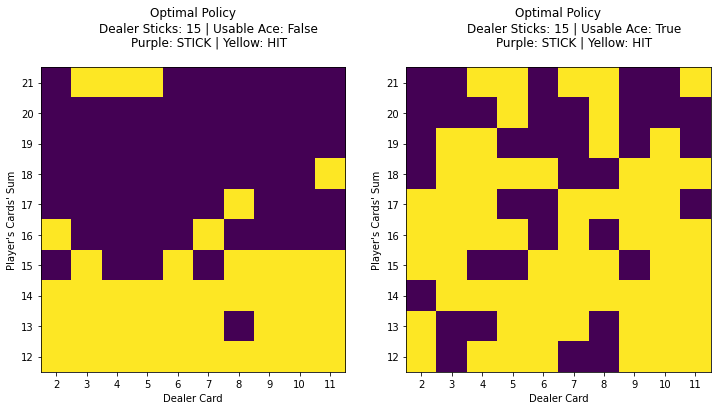

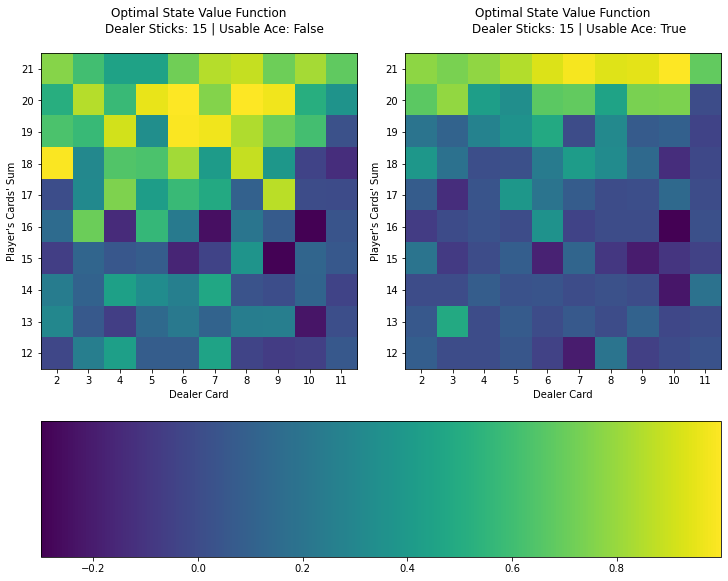

After 8000 episodes:


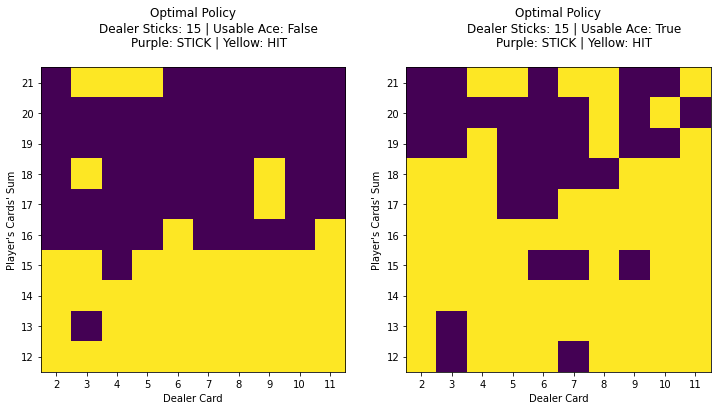

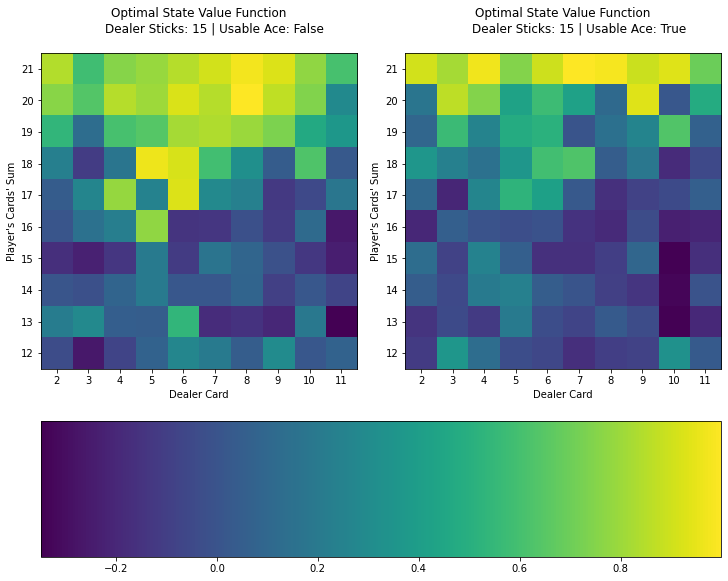

After 12000 episodes:


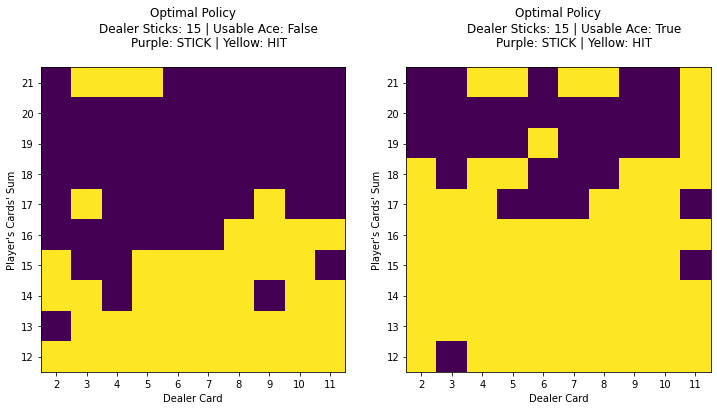

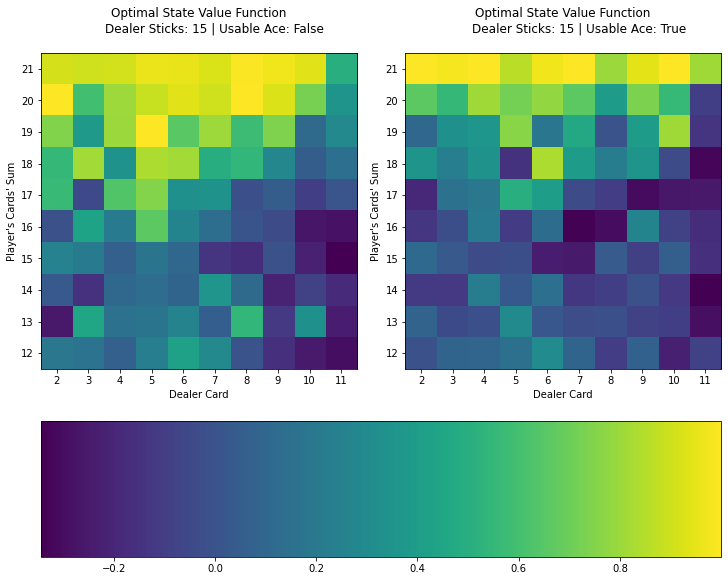

After 16000 episodes:


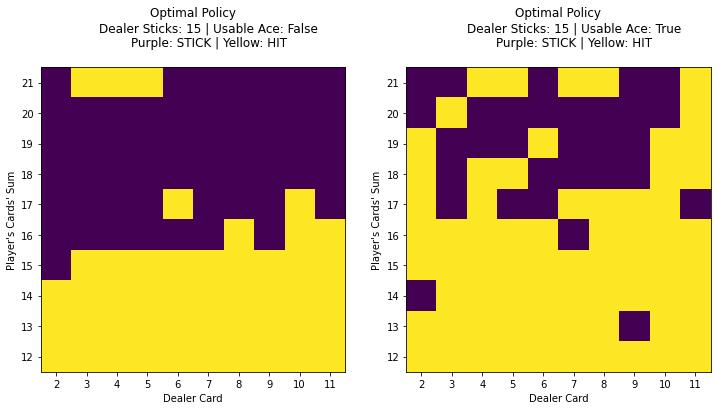

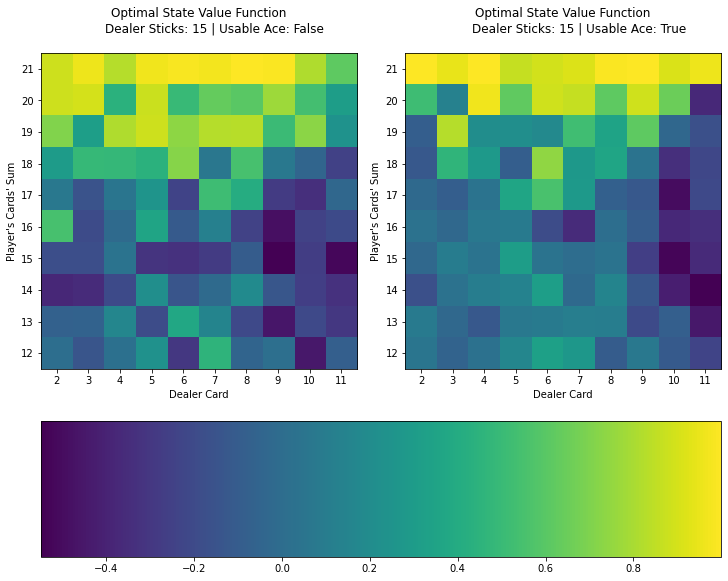

After 20000 episodes:


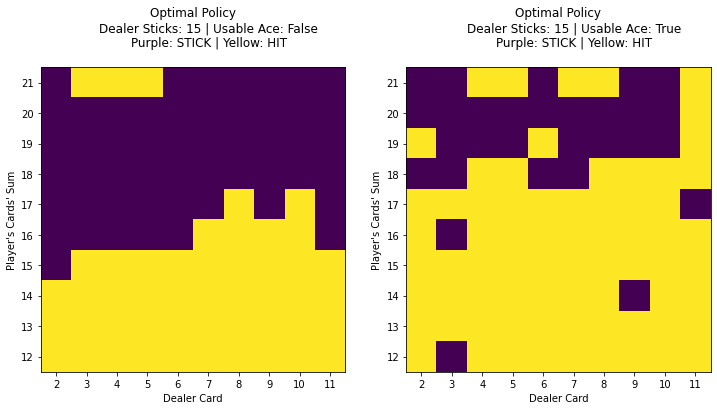

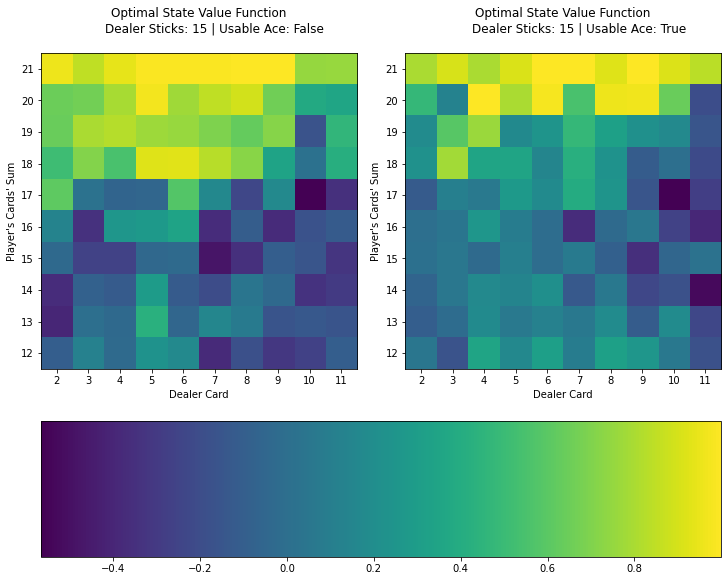

In [22]:
# Defining the characteristics for the environment
env_info = {"dealer_sticks": 15}

# Defining the characteristics for the agent
agent_info = {
    "discount": 1,       # UNDISCOUNTED
    "step_size": 0.2,
    "epsilon": 0.1,
    "seed": 0
}

q_optimal = run_experiment(env_info, agent_info, num_episode = 20000, plot = True)